## Inicjalizacja sparka

In [1]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("hive_pyspark") \
    .enableHiveSupport() \
    .getOrCreate()

25/01/10 10:21:44 WARN util.Utils: Your hostname, node1 resolves to a loopback address: 127.0.0.1; using 10.0.2.15 instead (on interface enp0s3)
25/01/10 10:21:44 WARN util.Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/01/10 10:21:45 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Wczytanie danych z tabel Hive

In [4]:
matches=spark.sql(f"""
    SELECT * 
    FROM matches
""")

weather=spark.sql(f"""
    SELECT * 
    FROM weather
""")

In [5]:
matches.printSchema()

root
 |-- season: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- round: integer (nullable = true)
 |-- attendance_value: double (nullable = true)
 |-- referee: string (nullable = true)
 |-- formation_home: string (nullable = true)
 |-- formation_away: string (nullable = true)
 |-- home_team: string (nullable = true)
 |-- away_team: string (nullable = true)
 |-- home_goals: integer (nullable = true)
 |-- home_shots: integer (nullable = true)
 |-- home_shots_on_target: integer (nullable = true)
 |-- home_passes_completed: integer (nullable = true)
 |-- home_passes: integer (nullable = true)
 |-- home_progressive_passes: integer (nullable = true)
 |-- home_passes_total_distance: double (nullable = true)
 |-- home_passes_progressive_distance: double (nullable = true)
 |-- home_passes_completed_short: integer (nullable = true)
 |-- home_passes_short: integer (nullable = true)
 |-- home_passes_completed_medium: integer (nullable = true)


In [6]:
matches.select("season", "date", "minute", "home_team", "away_team", "home_goals", "away_goals").show(5)

25/01/08 18:48:51 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

+---------+----------+------+---------+---------------+----------+----------+
|   season|      date|minute|home_team|      away_team|home_goals|away_goals|
+---------+----------+------+---------+---------------+----------+----------+
|2023-2024|2023-08-11|     1|  Burnley|Manchester City|         0|         1|
|2023-2024|2023-08-11|     2|  Burnley|Manchester City|         0|         1|
|2023-2024|2023-08-11|     3|  Burnley|Manchester City|         0|         1|
|2023-2024|2023-08-11|     4|  Burnley|Manchester City|         0|         1|
|2023-2024|2023-08-11|     5|  Burnley|Manchester City|         0|         1|
+---------+----------+------+---------+---------------+----------+----------+
only showing top 5 rows



In [7]:
weather.printSchema()

root
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- generationtime_ms: double (nullable = true)
 |-- utc_offset_seconds: integer (nullable = true)
 |-- timezone: string (nullable = true)
 |-- timezone_abbreviation: string (nullable = true)
 |-- elevation: double (nullable = true)
 |-- current_time: string (nullable = true)
 |-- current_interval: integer (nullable = true)
 |-- current_temperature_2m: double (nullable = true)
 |-- current_wind_speed_10m: double (nullable = true)
 |-- current_precipitation: double (nullable = true)
 |-- current_relative_humidity_2m: integer (nullable = true)
 |-- current_cloud_cover: integer (nullable = true)



In [8]:
weather.show(5)

+---------+------------+--------------------+------------------+--------+---------------------+---------+----------------+----------------+----------------------+----------------------+---------------------+----------------------------+-------------------+
| latitude|   longitude|   generationtime_ms|utc_offset_seconds|timezone|timezone_abbreviation|elevation|    current_time|current_interval|current_temperature_2m|current_wind_speed_10m|current_precipitation|current_relative_humidity_2m|current_cloud_cover|
+---------+------------+--------------------+------------------+--------+---------------------+---------+----------------+----------------+----------------------+----------------------+---------------------+----------------------------+-------------------+
|     51.5|-0.120000124| 0.04398822784423828|                 0|     GMT|                  GMT|     17.0|2024-12-15T11:45|             900|                  10.5|                  11.8|                  0.0|                      

## Przetwarzanie danych pogodowych

In [9]:
from pyspark.sql import functions as F

transformed_weather = weather.select(
    F.date_format(F.col('current_time'), 'yyyy-MM-dd').alias('date'),
    F.date_format(F.col('current_time'), 'HH:mm').alias('time'),
    F.col('longitude'),
    F.col('latitude'),
    F.col('current_temperature_2m').alias('weather_temperature'),
    F.col('current_precipitation').alias('weather_precipitation'),
    F.col('current_wind_speed_10m').alias('weather_wind'),
    F.col('current_relative_humidity_2m').alias('weather_humidity'),
    F.col('current_cloud_cover').alias('weather_cloud_cover')
)

In [10]:
transformed_weather.show(5)

+----------+-----+------------+---------+-------------------+---------------------+------------+----------------+-------------------+
|      date| time|   longitude| latitude|weather_temperature|weather_precipitation|weather_wind|weather_humidity|weather_cloud_cover|
+----------+-----+------------+---------+-------------------+---------------------+------------+----------------+-------------------+
|2024-12-15|11:45|-0.120000124|     51.5|               10.5|                  0.0|        11.8|              90|                 91|
|2024-12-15|11:45|       2.204|53.302002|                9.4|                  0.0|        42.1|              97|                100|
|2024-12-15|12:00|-0.120000124|     51.5|               10.6|                  0.0|        12.1|              89|                 98|
|2024-12-15|12:00|       2.204|53.302002|                9.4|                  0.0|        43.2|              97|                100|
|2024-12-15|12:30|-0.120000124|     51.5|               10.9| 

Nie mogliśmy pobrać tylu danych pogodowych za pomocą API w NIFI, dlatego sztucznie je uzupełnimy. Podobnie załadowaliśmy w NIFI kilka porcji danych z jednego sezonu Premier League, tutaj dołączymy dane z czterach kolejnych sezonów. Oczywiście tak jak zaprezentowaliśmy powyżej, wszytko działa w NIFI i gdyby spędzić nad tym wystarczająco dużo czasu można uzyskać dane, które tu sztucznie wczytujemy.

In [4]:
updated_matches = spark.read.option("header","true").option("inferschema","true").csv("hdfs://localhost:8020/user/kuba/football_data_csv/simulated_matches_final.csv")
updated_weather = spark.read.option("header","true").option("inferschema","true").csv("hdfs://localhost:8020/user/kuba/football_data_csv/weather_for_matches.csv")

In [23]:
updated_matches.select("season", "date", "time", "longitude", "latitude", "minute", "home_team", "away_team", "home_goals", "away_goals").show(5)

+---------+----------+-----+---------+--------+------+---------+---------------+----------+----------+
|   season|      date| time|longitude|latitude|minute|home_team|      away_team|home_goals|away_goals|
+---------+----------+-----+---------+--------+------+---------+---------------+----------+----------+
|2023-2024|2023-08-11|20:00|    -2.23| 53.7899|     1|  Burnley|Manchester City|         0|         1|
|2023-2024|2023-08-11|20:00|    -2.23| 53.7899|     2|  Burnley|Manchester City|         0|         1|
|2023-2024|2023-08-11|20:00|    -2.23| 53.7899|     3|  Burnley|Manchester City|         0|         1|
|2023-2024|2023-08-11|20:00|    -2.23| 53.7899|     4|  Burnley|Manchester City|         0|         1|
|2023-2024|2023-08-11|20:00|    -2.23| 53.7899|     5|  Burnley|Manchester City|         0|         1|
+---------+----------+-----+---------+--------+------+---------+---------------+----------+----------+
only showing top 5 rows



In [24]:
updated_weather.show(5)

+----------+-----+---------+--------+-------------------+---------------------+------------+----------------+-------------------+
|      date| time|longitude|latitude|weather_temperature|weather_precipitation|weather_wind|weather_humidity|weather_cloud_cover|
+----------+-----+---------+--------+-------------------+---------------------+------------+----------------+-------------------+
|2023-08-11|20:00|    -2.23| 53.7899|               17.0|                  0.0|        13.7|              70|                 14|
|2023-08-12|12:30|  -0.1086|  51.555|               19.5|                  0.2|        29.6|              68|                 45|
|2023-08-12|15:00|  -2.9662| 53.4388|               19.9|                  0.1|        28.6|              64|                 28|
|2023-08-12|15:00|  -1.4714| 53.3703|               20.1|                  0.0|        27.0|              69|                 30|
|2023-08-12|15:00|  -0.0837| 50.8616|               17.6|                  0.1|        34.

In [25]:
updated_matches = updated_matches.withColumnRenamed('date', 'match_date') \
                                 .withColumnRenamed('time', 'match_time') \
                                 .withColumnRenamed('longitude', 'match_longitude') \
                                 .withColumnRenamed('latitude', 'match_latitude')

updated_weather = updated_weather.withColumnRenamed('date', 'weather_date') \
                                 .withColumnRenamed('time', 'weather_time') \
                                 .withColumnRenamed('longitude', 'weather_longitude') \
                                 .withColumnRenamed('latitude', 'weather_latitude')

matches_with_weather = updated_matches.join(
    updated_weather,
    (updated_matches['match_date'] == updated_weather['weather_date']) &
    (updated_matches['match_time'] == updated_weather['weather_time']) &
    (updated_matches['match_longitude'] == updated_weather['weather_longitude']) &
    (updated_matches['match_latitude'] == updated_weather['weather_latitude']),
    'inner'
)

In [26]:
matches_with_weather = matches_with_weather.drop('weather_date', 'weather_time', 'weather_longitude', 'weather_latitude')

In [27]:
matches_with_weather.printSchema()

root
 |-- season: string (nullable = true)
 |-- match_date: string (nullable = true)
 |-- match_time: string (nullable = true)
 |-- round: integer (nullable = true)
 |-- attendance_value: double (nullable = true)
 |-- referee: string (nullable = true)
 |-- formation_home: string (nullable = true)
 |-- formation_away: string (nullable = true)
 |-- home_team: string (nullable = true)
 |-- away_team: string (nullable = true)
 |-- home_goals: integer (nullable = true)
 |-- home_shots: integer (nullable = true)
 |-- home_shots_on_target: integer (nullable = true)
 |-- home_passes_completed: integer (nullable = true)
 |-- home_passes: integer (nullable = true)
 |-- home_progressive_passes: integer (nullable = true)
 |-- home_passes_total_distance: integer (nullable = true)
 |-- home_passes_progressive_distance: integer (nullable = true)
 |-- home_passes_completed_short: integer (nullable = true)
 |-- home_passes_short: integer (nullable = true)
 |-- home_passes_completed_medium: integer (nul

In [28]:
matches_with_weather.select("season", "match_date", "match_time", "minute", "home_team", "away_team", "home_goals", "away_goals", "weather_temperature","weather_precipitation","weather_wind","weather_humidity", "weather_cloud_cover").show(5)

+---------+----------+----------+------+---------+---------------+----------+----------+-------------------+---------------------+------------+----------------+-------------------+
|   season|match_date|match_time|minute|home_team|      away_team|home_goals|away_goals|weather_temperature|weather_precipitation|weather_wind|weather_humidity|weather_cloud_cover|
+---------+----------+----------+------+---------+---------------+----------+----------+-------------------+---------------------+------------+----------------+-------------------+
|2023-2024|2023-08-11|     20:00|     1|  Burnley|Manchester City|         0|         1|               17.0|                  0.0|        13.7|              70|                 14|
|2023-2024|2023-08-11|     20:00|     2|  Burnley|Manchester City|         0|         1|               17.0|                  0.0|        13.7|              70|                 14|
|2023-2024|2023-08-11|     20:00|     3|  Burnley|Manchester City|         0|         1|       

## Załadowanie danych do HBase


In [29]:
import happybase

In [30]:
matchesFamilies = {
    'season': 'match_info',
    'match_date': 'match_info',
    'match_time': 'match_info',
    'round': 'match_info',
    'attendance_value': 'match_info',
    'referee': 'match_info',
    'formation_home': 'team_info',
    'formation_away': 'team_info',
    'home_team': 'team_info',
    'away_team': 'team_info',
    'home_goals': 'stats',
    'away_goals': 'stats',
    'home_shots': 'stats',
    'away_shots': 'stats',
    'home_shots_on_target': 'stats',
    'away_shots_on_target': 'stats',
    'home_passes_completed': 'stats',
    'away_passes_completed': 'stats',
    'home_passes': 'stats',
    'away_passes': 'stats',
    'home_progressive_passes': 'stats',
    'away_progressive_passes': 'stats',
    'home_passes_total_distance': 'stats',
    'away_passes_total_distance': 'stats',
    'home_passes_progressive_distance': 'stats',
    'away_passes_progressive_distance': 'stats',
    'home_assisted_shots': 'stats',
    'away_assisted_shots': 'stats',
    'home_passes_into_final_third': 'stats',
    'away_passes_into_final_third': 'stats',
    'home_passes_into_penalty_area': 'stats',
    'away_passes_into_penalty_area': 'stats',
    'home_own_goals': 'stats',
    'away_own_goals': 'stats',
    'minute': 'match_timeline',
    'match_latitude': 'location',
    'match_longitude': 'location',
    'weather_temperature': 'weather',
    'weather_precipitation': 'weather',
    'weather_wind': 'weather',
    'weather_humidity': 'weather',
    'weather_cloud_cover': 'weather'
}

In [70]:
connection = happybase.Connection('localhost')
connection.open()

In [32]:
import uuid

In [ ]:
col_families = {
    'match_info': dict(),
    'team_info': dict(),
    'stats': dict(),
    'match_timeline': dict(),
    'location': dict(),
    'weather': dict()
}

connection.create_table('matches_data', col_families)

In [41]:
matches_with_weather.limit(1)

DataFrame[season: string, match_date: string, match_time: string, round: int, attendance_value: double, referee: string, formation_home: string, formation_away: string, home_team: string, away_team: string, home_goals: int, home_shots: int, home_shots_on_target: int, home_passes_completed: int, home_passes: int, home_progressive_passes: int, home_passes_total_distance: int, home_passes_progressive_distance: int, home_passes_completed_short: int, home_passes_short: int, home_passes_completed_medium: int, home_passes_medium: int, home_passes_completed_long: int, home_passes_long: int, home_assisted_shots: int, home_passes_into_final_third: int, home_passes_into_penalty_area: int, home_passes_live: int, home_passes_dead: int, home_passes_free_kicks: int, home_passes_switches: int, home_passes_offsides: int, home_passes_blocked: int, home_blocked_shots: int, home_blocked_passes: int, home_passes_received: int, home_progressive_passes_received: int, home_own_goals: int, away_goals: int, awa

In [36]:
def save_hbase(dataframe, target_table, column_family_mapping, hbase_connection):
    table = hbase_connection.table(target_table)
    rdd_data = dataframe.rdd
    for row in rdd_data.collect():
        row_key = str(uuid.uuid4())
        row_data = {}
        
        for column, value in zip(dataframe.columns, row):
            if column in column_family_mapping:
                family = column_family_mapping[column]
                row_data[f"{family}:{column}"] = str(value)
        
        table.put(row_key, row_data)


In [50]:
save_hbase(matches_with_weather, 'matches_data', matchesFamilies, connection)

## Wykresy

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
matches_pd = updated_matches.toPandas()
weather_pd = updated_weather.toPandas()

25/01/18 10:34:26 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

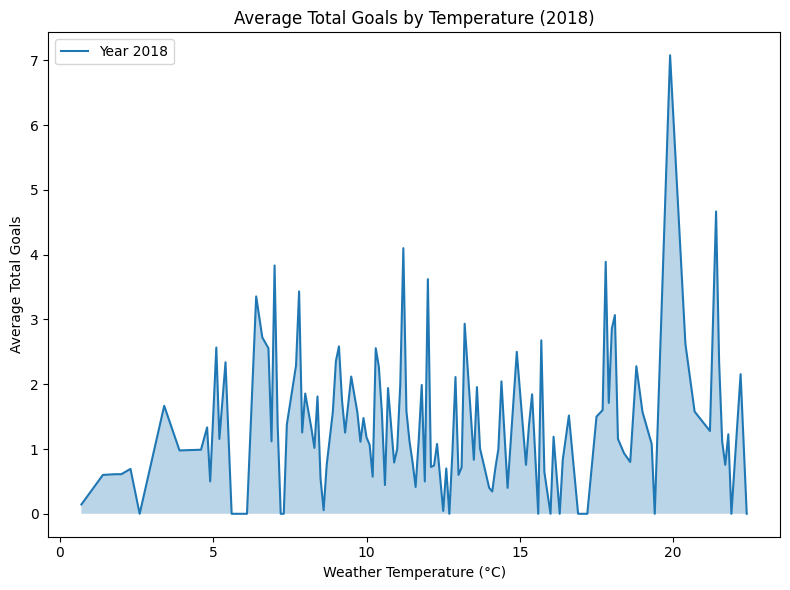

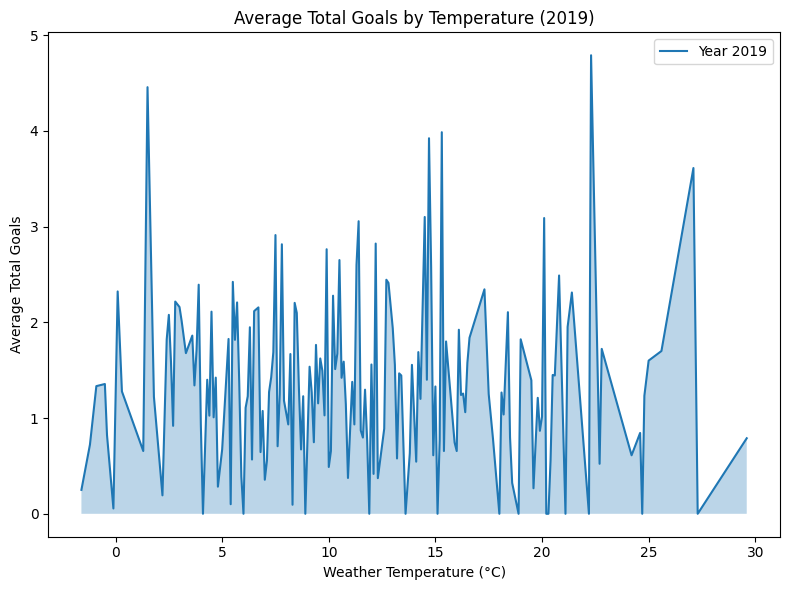

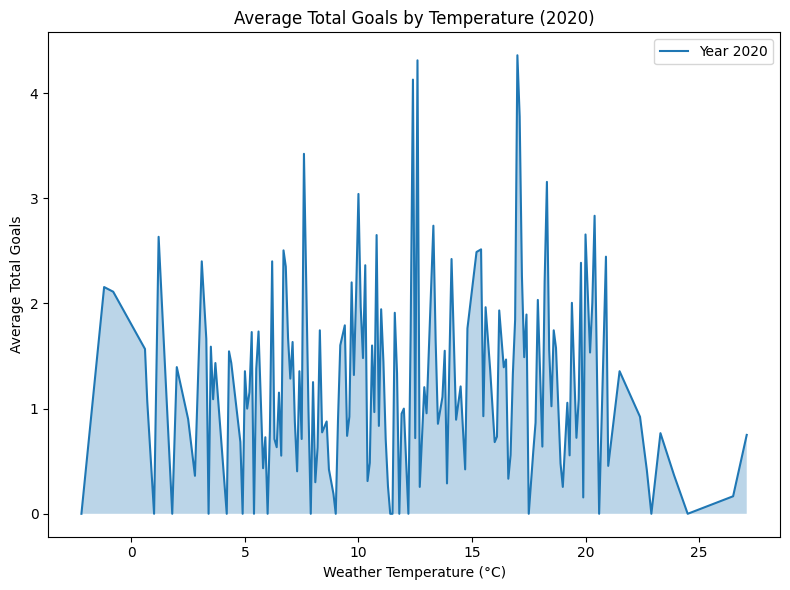

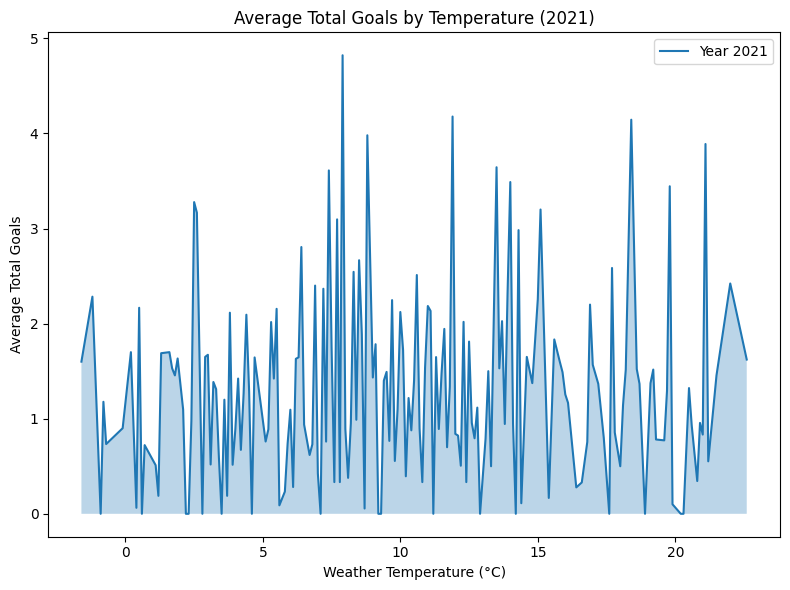

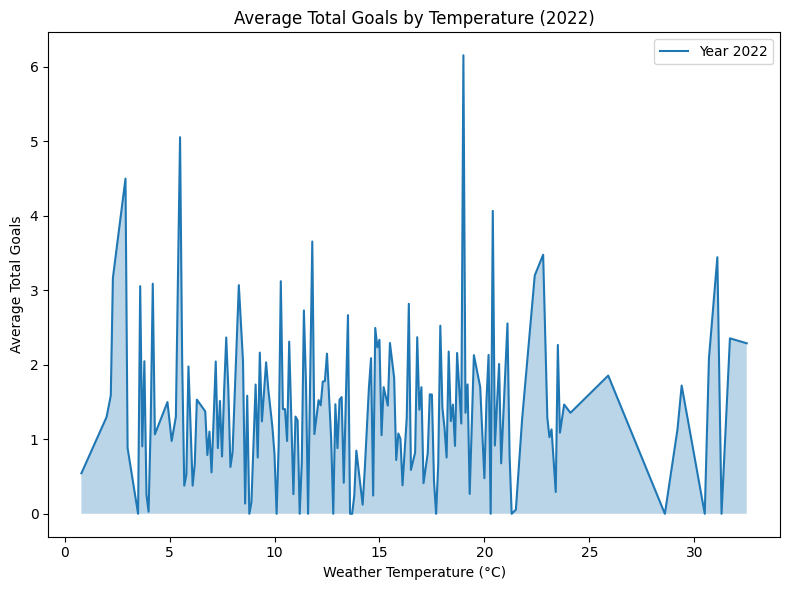

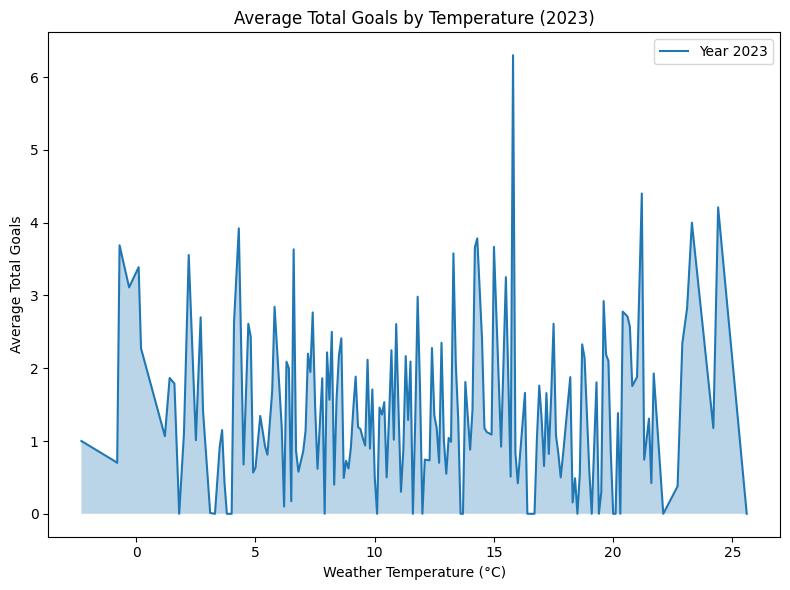

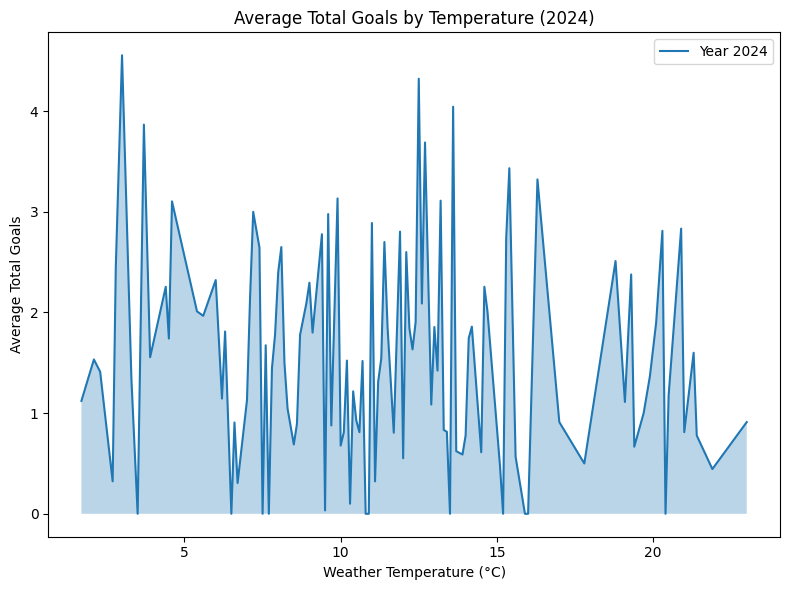

In [16]:
merged_df = pd.merge(matches_pd, weather_pd, on=['date', 'time', 'latitude', 'longitude'], how='inner')

merged_df['total_goals'] = merged_df['home_goals'] + merged_df['away_goals']
merged_df['date_dt'] = pd.to_datetime(merged_df['date'], errors='coerce')
merged_df['year'] = merged_df['date_dt'].dt.year

# Data for Plot 1
df_temp_goals = (
    merged_df
    .groupby(['year', 'weather_temperature'], as_index=False)['total_goals']
    .mean()
)

# Wykres 1: Average Total Goals by Temperature
sorted_years = sorted(df_temp_goals['year'].dropna().unique())
for y in sorted_years:
    subset = df_temp_goals[df_temp_goals['year'] == y]
    subset = subset.sort_values(by='weather_temperature')
    
    plt.figure(figsize=(8, 6))
    plt.plot(subset['weather_temperature'], subset['total_goals'], label=f'Year {y}')
    plt.fill_between(subset['weather_temperature'], subset['total_goals'], alpha=0.3)
    plt.title(f"Average Total Goals by Temperature ({int(y)})")
    plt.xlabel("Weather Temperature (°C)")
    plt.ylabel("Average Total Goals")
    plt.legend()
    plt.tight_layout()
    plt.show()